# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13770268768240188319
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3421237248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3958598532417257176
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


This can take a bit of time if it's the first time you're running it. It will download a Keras model equivalent to VGG-16.

## Build Model

In [2]:
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Sequential, Model

def ConvBlock(layers, model, num_filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers):
#         model.add(ZeroPadding2D((1,1))) # zero padding of size 1
        model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same')) # 3x3 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_first'))

def FCBlock(model, size=4096):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(size, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)

    model.add(Dense(37, activation = 'sigmoid'))
    return model

Using TensorFlow backend.


In [3]:
from keras.optimizers import RMSprop


# Then create the corresponding model 
my_model = my_VGG16()
optimizer = RMSprop(lr=1e-6)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 106, 106)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 106, 64)        61120     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 106, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 53, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 53, 128)        36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 53, 128)        147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 26, 64)         0         
__________

# Paths and Data Splitting
Remember to check for the path of the directory

In [23]:
import glob
import pandas as pd
import numpy as np

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1_pp'
all_files = pd.DataFrame(load_img_paths(original_data_dir))

all_files = all_files.sample(frac=1) # shuffle
frac = int(all_files.shape[0] * 0.95)
train_paths = all_files[:frac][0].values.tolist()
valid_paths = all_files[frac:][0].values.tolist()

train_paths[0:5]

['../data/images_training_rev1_pp\\860466.jpg',
 '../data/images_training_rev1_pp\\274803.jpg',
 '../data/images_training_rev1_pp\\297601.jpg',
 '../data/images_training_rev1_pp\\258957.jpg',
 '../data/images_training_rev1_pp\\471940.jpg']

In [10]:
df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Training

In [18]:
from os import path

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths, batch_size=32):
    while 1: # while 1 makes it loop around when outerloop finishes
        for i in range(0,len(paths),batch_size):
            X = np.zeros(shape=(batch_size, 3, 106, 106))
            y = np.zeros(shape=(batch_size, 37))
            for j in range(batch_size):
                ind = (i+j) % len(paths)
                fname = paths[ind]
                image = imread(paths[ind]).T
                X[j] = img_to_array(image)
                file_id = path.split(fname)[-1] \
                              .split('.')[0]
                fd = int(file_id)
                y[j] = df.loc[df['GalaxyID'] == fd].loc[:,df.columns != 'GalaxyID']
            yield (X, y)
        
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [19]:
batch_size = 32
steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Traning images:    58499
Validation images: 3079
Training steps:    1828
Validation steps:  96


In [20]:
hist = my_model.fit_generator(fetch_images(train_paths, batch_size),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths, batch_size),
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 158s - loss: 0.0365 - val_loss: 0.0238

Epoch 00001: val_loss improved from inf to 0.02385, saving model to tmp/weights.hdf5
Epoch 2/50
 - 155s - loss: 0.0243 - val_loss: 0.0210

Epoch 00002: val_loss improved from 0.02385 to 0.02096, saving model to tmp/weights.hdf5
Epoch 3/50


KeyboardInterrupt: 

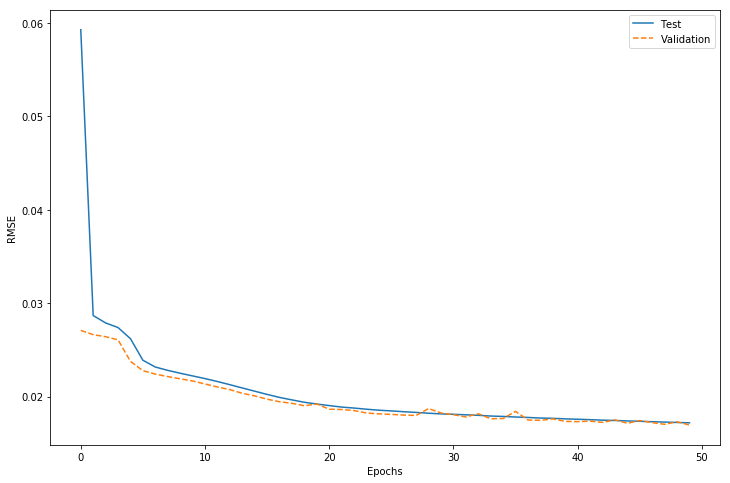

In [25]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()